In [59]:
# next steps:

# new loss?
# train on azure?
# 100 x 100 pixels and 5 layers, 64... 1024

In [39]:
# preprocessing 
import cv2
import os
import numpy as np
from PIL import Image, ImageOps

WORKING_PATH = os.getcwd() # called in notebook for working dir
DATASET_PATH = os.path.join(WORKING_PATH, "data")
BASE_OUTPUT = os.path.join(WORKING_PATH, "outputs")
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "raw", "images") # , "subcatsFraw")#
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "raw", "annotations", "trimaps") #  "subcatsLraw")#
RESIZE_FEATURES_PATH = os.path.join(DATASET_PATH, "preproccessed",  "features") # "subcats_F")#
RESIZE_LABELS_PATH = os.path.join(DATASET_PATH, "preproccessed",  "labels")#'  "subcats_L")#

def ensure_divisible(num, denom):
    """Ensures input number is divisable by denom, with a goal that both width and height will be even. 
    This is so when downsampling/ upsampling in unet, each skpped connection matches up 
    when concating in the upscale section ie skipped connection and convoluted img match dims."""
    if num % denom == 0:
        return num
    else:
        return_num = num
        while return_num % denom != 0:
            return_num += 1
        return return_num

def resize_with_padding(img, expected_size, colour):
    """Resizes images with padding and scaling to expected sizes using PIL."""
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0] # get 
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, fill = colour)

def binary_mask(pil_img):
    """Takes image path as input and returns binary (0, or 255 in RGB) image."""
    img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img = np.array(img)
    img_copy = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] in (3,1): # if outline
                img_copy[i, j] = 1
            else:
                img_copy[i, j] = 0
    img_copy =   cv2.morphologyEx(img_copy, cv2.MORPH_CLOSE, iterations=10, kernel=(3,3))
    pil_img_rtn = Image.fromarray(img_copy)
    return pil_img_rtn

#### below code gets avg width and height 
width_list = []
height_list = []
faulty_file_names = []
for filename_full in os.listdir(IMAGE_DATASET_PATH):
    file_path = os.path.join(IMAGE_DATASET_PATH, filename_full)
    if os.path.isfile(file_path):
        filename_split = filename_full.split(".")
        filename, ext = filename_split[0], filename_split[1]
        try:
            img = cv2.imread(file_path)
            image_shape = img.shape
            width, height = image_shape[1], image_shape[0]
            width_list.append(width); height_list.append(height) # check dimensions to find most common 
        except: 
            faulty_file_names.append(filename) # check which cv2 struggles to open so we can drop from images and labels 
####

# get mean width/ height to rescale to this
scale_down = 4
num_features_UNET = 4
denom = num_features_UNET**2 # each feature must be squared as this is the downsample rate, so to match with upsample in UNET. Ie 4 features, needs to be able to be halved 4 times to matchthe up sample.
mean_width = ensure_divisible(int(np.mean(width_list)/scale_down), denom)
mean_height = ensure_divisible(int(np.mean(height_list)/scale_down), denom)

size = max(mean_width, mean_height) # in experimentation ive found better to do squares (with padding) so that convolution can be applied to both axis
mean_width, mean_height=size,size
print(f"\n\nMean width and height: {mean_width, mean_height}\n\n")

# Once got mean width and height, resize img labels and training data to mean (taking mean is less computationally expensive overall as it represents mid point of data)
for filename_full in os.listdir(IMAGE_DATASET_PATH): # iterate again and scale to same size. 
    if filename_full[0].isupper(): # checks if upper file name - therefore only cats
        file_path = os.path.join(IMAGE_DATASET_PATH, filename_full)
        if os.path.isfile(file_path):
            filename_split = filename_full.split(".")
            filename, ext = filename_split[0], filename_split[1]
            if filename not in faulty_file_names: # only get non-errors
                try:# try except due to some issues with libraries being used. 
                    # X images resize
                    img_feature = Image.open(file_path)
                    resize_img_feature = resize_with_padding(img_feature, (mean_width, mean_height), (0, 0, 0))  
                                
                    # y labels resize and binary
                    label_file_path = os.path.join(MASK_DATASET_PATH, filename + ".png")
                    img_label = Image.open(label_file_path)
                    resize_img_label = resize_with_padding(img_label, (mean_width, mean_height), 2)
                    pil_binary_mask = binary_mask(resize_img_label)
                    
                    # Save
                    resize_img_feature.save(os.path.join(RESIZE_FEATURES_PATH, filename + ".png"))
                    pil_binary_mask.save(os.path.join(RESIZE_LABELS_PATH, filename + ".png"))
                except: 
                    pass
            
print(f"Difference in features and labels: {len(os.listdir(RESIZE_FEATURES_PATH)) - len(os.listdir(RESIZE_LABELS_PATH))}")



Mean width and height: (112, 112)


Difference in features and labels: 0


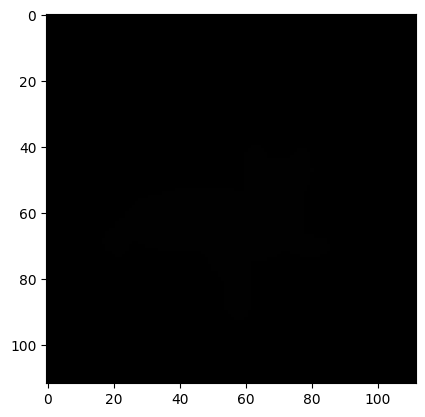

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("C:\\Users\\henrytaylor\\Desktop\\Current Project\\IP\\ds-toolkit\\ComputerVisionDemo\\development\\segmentation_model\\data\\preproccessed\\labels\\Abyssinian_1.png")

plt.imshow(img)
# img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, iterations=10, kernel=(2,2))
# cv2.imshow("text", img); cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1) # Displaying the image and destroys windows when keyboard key is pressed

In [14]:

# import cv2
# import os
# import numpy as np
# from PIL import Image, ImageOps
# import matplotlib.pyplot as plt

# WORKING_PATH = os.getcwd() # called in notebook for working dir
# DATASET_PATH = os.path.join(WORKING_PATH, "data")
# BASE_OUTPUT = os.path.join(WORKING_PATH, "outputs")
# IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "raw", "images")
# MASK_DATASET_PATH = os.path.join(DATASET_PATH, "raw", "annotations", "trimaps")
# RESIZE_FEATURES_PATH = os.path.join(DATASET_PATH, "preproccessed", "features")
# RESIZE_LABELS_PATH = os.path.join(DATASET_PATH, "preproccessed", "labels")

# def show_image_mask(img, mask, cmap='gray'): 
#     fig = plt.figure(figsize=(5,5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(img, cmap=cmap)
#     plt.axis('off')
#     plt.subplot(1, 2, 2)
#     plt.imshow(mask, cmap=cmap)
#     plt.axis('off')

# name = "yorkshire_terrier_197.png"
# image = cv2.imread(os.path.join(RESIZE_FEATURES_PATH,name), cv2.IMREAD_UNCHANGED)
# mask = cv2.imread(os.path.join(RESIZE_LABELS_PATH, name), cv2.IMREAD_UNCHANGED)
# show_image_mask(image, mask, cmap='gray')


In [58]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

import torch
from torch.utils.data import Dataset
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.optim import Adam, AdamW
import torch.nn as nn
import gc

# clear memory
torch.cuda.empty_cache()
gc.collect()

WORKING_PATH = os.getcwd() # called in notebook for working dir
# Inputs
RESIZE_FEATURES_PATH = os.path.join(WORKING_PATH, "data", "preproccessed", "a_cats_F")#"features")
RESIZE_LABELS_PATH = os.path.join(WORKING_PATH, "data", "preproccessed",  "a_cats_L")#"labels")
# Outputs
BASE_OUTPUT = os.path.join(WORKING_PATH, "outputs")
PLOT_PATH = os.path.join(BASE_OUTPUT, "plot.png")
MODEL_PATH = os.path.join(BASE_OUTPUT, "model.pkl")
TEST_PATHS = os.path.join(BASE_OUTPUT, "test_paths.txt")

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
print(f"[INFO] training on device: {DEVICE}")

# define dataset loader
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		self.imagePaths = imagePaths # features
		self.maskPaths = maskPaths # labels/ masks
  
	def __len__(self):
		return len(self.imagePaths) # return the number of total samples contained in the dataset

	def __getitem__(self, idx):
		imagePath = self.imagePaths[idx]
		maskPath = self.maskPaths[idx]
		data = cv2.imread(imagePath, cv2.COLOR_BGRA2RGB)
		label = cv2.imread(maskPath, cv2.IMREAD_UNCHANGED)
		return (torch.from_numpy(data).float(), torch.from_numpy(label))

class DoubleConv(nn.Module):
    """https://www.youtube.com/watch?v=IHq1t7NxS8k"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__() # what does super do?
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # set bias to false as using batchnorm (cancels bias)
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module): # means inherit from nn.module
    def __init__(self, in_channels=3, out_channels=1, features = [128,256,512,1024]): # channels refer to channel so rgb 
        """init creates arcitecture for the class instance. """
        super(UNet, self,).__init__()
        self.downs = nn.ModuleList() # lists that store convolution layers, module list 
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (kernel_size=2, stride=2) = divisible by 2
        
        for feature in features: # down blocks of UNET, go through features 
            self.downs.append(DoubleConv(in_channels = in_channels, out_channels = feature)) # add layer to UNET
            in_channels = feature # set new in channels as last our channel
            
        self.bottleneck = DoubleConv(in_channels = features[-1], out_channels = features[-1] * 2) # bottleneck. Last feature in list in and then last feqature x 2 to go out
        
        for feature in reversed(features): # up blocks
            self.ups.append(
                nn.ConvTranspose2d(in_channels = feature*2, out_channels = feature, kernel_size=2, stride=2)) # up sample 
            self.ups.append(
                DoubleConv(in_channels = feature*2, out_channels = feature)) # 2 convolutions

        # final conv layer
        self.finalConv = nn.Conv2d(in_channels=features[0], out_channels=out_channels, kernel_size = 1) # change number of channels 
        
    def forward(self, x):
        skip_connections = [] # store all the skip connections
        for down in self.downs: # down blocks
            x = down(x) # doubleconv
            skip_connections.append(x) # used to take across the U
            x = self.pool(x) # down sampling

        x = self.bottleneck(x) # bottleneck and double conv
        skip_connections = skip_connections[::-1] # inverse skip connections (as we will use them in reverse order that we added them)
        
        for idx in range(0,len(self.ups),2):  # loop through every 2 ups (as each up step has the ConvTranspose and the DoubleConv)  
            x = self.ups[idx](x) # convtranspose (up sampling)
            skipped_connection = skip_connections[idx//2] # get the skipped connection
            concat_skip = torch.cat((skipped_connection,x),dim=1) # Dim 1 is channel dim. Concatenate upsampled activation maps with skipped connection
            x = self.ups[idx+1](concat_skip) # doubleconv with concatenated activation maps

        x = self.finalConv(x) # do final convolution to get mask
        return torch.sigmoid(x)
    
def convertTime(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return "%d:%02d:%02d" % (hour, minutes, seconds)
    
# load the image and mask filepaths in a sorted manner
imagePaths = [RESIZE_FEATURES_PATH + "/" + filename for filename in sorted(list(os.listdir(RESIZE_FEATURES_PATH)))]
maskPaths = [RESIZE_LABELS_PATH + "/" + filename for filename in sorted(list(os.listdir(RESIZE_LABELS_PATH)))]

trainTest_split = train_test_split(imagePaths, maskPaths, test_size=0.10, random_state=37)
(trainImages, testImages) = trainTest_split[:2] # unpack the data split
(trainMasks, testMasks) = trainTest_split[2:]
trainVal_split = train_test_split(trainImages, trainMasks, test_size=0.05, random_state=37)
(trainImages, valImages) = trainVal_split[:2] # unpack the data split
(trainMasks, valMasks) = trainVal_split[2:]

with open(TEST_PATHS, "w") as f:
	f.write("\n".join(testImages)) # write the testing image paths to disk so that we can use then when evaluating/testing our model
	f.close()
print("[INFO] saving testing image paths...")

trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
valDS = SegmentationDataset(imagePaths=valImages, maskPaths=valMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] {len(trainDS)} examples in the training set.\n[INFO] {len(testDS)} examples in the test set.\n[INFO] {len(valDS)} examples in the validation set.")

width = 112
height = 112
batch_size = 34
num_epochs = 20
lr_INIT=0.001

# get validation set
val_inputs = torch.tensor([])
val_masks = torch.tensor([])
for image_idx in range(0,len(valDS)): # for image in batch, j = 0,1,2,3,4 (for batchsize 5)
    DS_object = valDS[image_idx] # get image and mask at index
    input = torch.reshape(DS_object[0],(1,3,width,height)) # reshape to be img num, channels, width, heigght
    mask = torch.reshape(DS_object[1],(1,width,height)) # reshape to be channels, width, heigght
    val_inputs = torch.cat((val_inputs,input),0) # concatenate image along img num and mask to lists of images and masks
    val_masks = torch.cat((val_masks,mask),0)
val_masksL = val_masks.type(torch.FloatTensor) # put masks form that criterion wants
print(f"[INFO] Created Validation Set for Loss Stats.")

number_batches = int(np.ceil(len(trainDS) / batch_size))
model = UNet(in_channels=3, out_channels=1)
criterion = BCELoss() # we can use binary cross entropy with logit OR use sigmoid on last step and use BCELoss
optimizer = AdamW(model.parameters(), lr=lr_INIT)

highestValLoss = np.inf # initilise as high
best_epoch = 0
train_hist = {}
train_hist["train_loss"] = []; train_hist["val_loss"] = []
start_time = time.time()
for epoch in range(num_epochs):
    epochVal = 0
    for batch_num, batch_idx in enumerate(range(0,len(trainDS)-1,batch_size)):   # for each batch, i = 0,5,10 etc (for batchsize 5)
        train_inputs = torch.tensor([])
        train_masks = torch.tensor([])
        # forward
        for image_idx in range(0,batch_size): # for image in batch, j = 0,1,2,3,4 (for batchsize 5)
            DS_object = trainDS[batch_idx+image_idx] # get image and mask at index
            input = torch.reshape(DS_object[0],(1,3,width,height)) # reshape to be img num, channels, width, heigght
            mask = torch.reshape(DS_object[1],(1,width,height)) # reshape to be channels, width, heigght
            train_inputs = torch.cat((train_inputs,input),0) # concatenate image along img num and mask to lists of images and masks
            train_masks = torch.cat((train_masks,mask),0)

        # backward
        optimizer.zero_grad()
        train_inputs = torch.reshape(train_inputs,(batch_size, 3, width, height))   # get predictions and predicted mask
        train_preds = model(train_inputs).reshape(batch_size, width, height) # reshape as these are pred masks ie batch x out channel (1) x width x height

        # train loss    
        train_masksL = train_masks.type(torch.FloatTensor) # put masks form that criterion wants
        train_loss = criterion(train_preds, train_masksL) # get loss
        train_loss.backward() # backpropogate
        optimizer.step()
        
        # val loss    
        val_preds = model(val_inputs).reshape(len(val_inputs), width, height) # reshape as these are pred masks ie batch x out channel (1) x width x height
        val_loss = criterion(val_preds, val_masksL) # get loss      
        epochVal += val_loss
        
        # end of batch stats
        batch_endTime = time.time()
        batch_timeDelta = convertTime(batch_endTime - start_time)
        train_loss_list, val_loss_list =  train_hist["train_loss"], train_hist["val_loss"]
        train_loss_list.append(train_loss.item()); val_loss_list.append(val_loss.item())
        train_hist["train_loss"], train_hist["val_loss"] = train_loss_list, val_loss_list
        print(f"[INFO] Time Elapsed: {batch_timeDelta} | Epoch:{epoch+1}/{num_epochs} | Batch:{batch_num+1}/{number_batches} | Train Loss:{train_loss.item()} | Validation Loss:{val_loss.item()}")

    epoch_endTime = time.time()
    epoch_timeDelta = convertTime(epoch_endTime - start_time)
    epoch_infostr = f"\n[INFO] Time Elapsed: {epoch_timeDelta} | Epoch:{epoch+1}/{num_epochs}\n"
    avgEpochVal = epochVal/number_batches
    if (avgEpochVal < highestValLoss): # save after every epoch if better then best val loss
        epoch_infostr = f"\n[INFO] Time Elapsed: {epoch_timeDelta} | Epoch:{epoch+1}/{num_epochs}\n         Saving model: Epoch Avg Val Loss ({avgEpochVal}) < previous best ({highestValLoss})\n"
        highestValLoss = avgEpochVal
        best_epoch = epoch+1
        torch.save(model.state_dict(), MODEL_PATH)
    print(epoch_infostr)

[INFO] training on device: cuda
[INFO] saving testing image paths...
[INFO] 170 examples in the training set.
[INFO] 20 examples in the test set.
[INFO] 9 examples in the validation set.
[INFO] Created Validation Set for Loss Stats.
[INFO] Time Elapsed: 0:00:32 | Epoch:1/20 | Batch:1/5 | Train Loss:0.7331456542015076 | Validation Loss:0.8150867223739624
[INFO] Time Elapsed: 0:01:06 | Epoch:1/20 | Batch:2/5 | Train Loss:0.7553216814994812 | Validation Loss:0.7505180835723877
[INFO] Time Elapsed: 0:01:40 | Epoch:1/20 | Batch:3/5 | Train Loss:0.7845945954322815 | Validation Loss:0.7347309589385986
[INFO] Time Elapsed: 0:02:17 | Epoch:1/20 | Batch:4/5 | Train Loss:0.6570720076560974 | Validation Loss:0.6950615644454956
[INFO] Time Elapsed: 0:02:55 | Epoch:1/20 | Batch:5/5 | Train Loss:0.6083820462226868 | Validation Loss:0.6675102710723877

[INFO] Time Elapsed: 0:02:55 | Epoch:1/20
         Saving model: Epoch Avg Val Loss (0.7325815558433533) < previous best (inf)

[INFO] Time Elapsed: 0:

In [49]:
# get test_ set
test_inputs = torch.tensor([])
test_masks = torch.tensor([])
for image_idx in range(0,len(testDS)): # for image in batch, j = 0,1,2,3,4 (for batchsize 5)
    DS_object = testDS[image_idx] # get image and mask at index
    input = torch.reshape(DS_object[0],(1,3,width,height)) # reshape to be img num, channels, width, heigght
    mask = torch.reshape(DS_object[1],(1,width,height)) # reshape to be channels, width, heigght
    test_inputs = torch.cat((test_inputs,input),0) # concatenate image along img num and mask to lists of images and masks
    test_masks = torch.cat((test_masks,mask),0)
test_masksL = test_masks.type(torch.FloatTensor) # put masks form that criterion wants
test_preds = model(test_inputs).reshape(len(test_inputs), width, height) # reshape as these are pred masks ie batch x out channel (1) x width x height

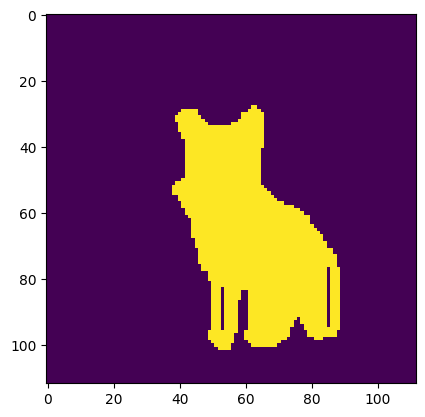

In [56]:
thresh=0.5
idx = 3
plt.imshow(torch.reshape(test_inputs[idx],(width,height,3)).numpy().astype(int))
plt.imshow(torch.reshape(test_masksL[idx],(width,height,1)).numpy().astype(int))

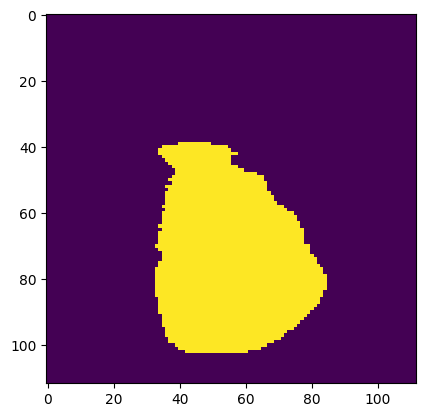

In [57]:
pred = torch.reshape(test_preds[idx],(width,height,1)).detach().numpy()
pred_copy = pred.copy()
pred_copy[pred_copy>thresh] = 1
pred_copy[pred_copy<=thresh] = 0
plt.imshow(pred_copy)
plt.show()

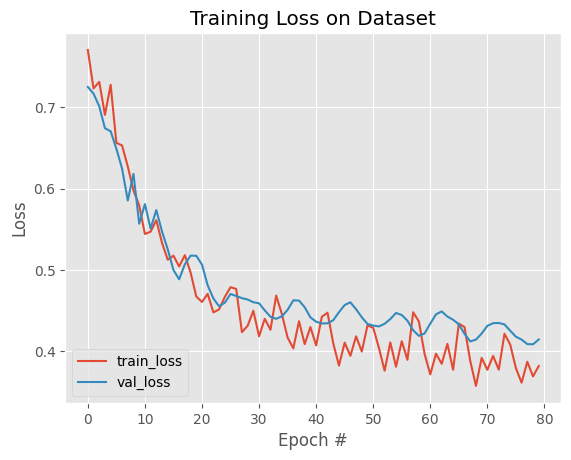

In [5]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(train_hist["train_loss"], label="train_loss")
plt.plot(train_hist["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

# torch.save(unet, MODEL_PATH) # serialize the model to disk

In [6]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
 
def make_predictions(model, imagePath):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it to float data type, and scale its pixel values
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image.astype("float32") / 255.0
		orig = image.copy()
		# find the filename and generate the path to ground truth mask
		filename =  imagePath.split("/")[-1]
		gtMask = cv2.imread(os.path.join(RESIZE_LABELS_PATH, filename), 0) # load the ground-truth segmentation mask in grayscale mode

  		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the current device
		image = np.transpose(image, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
		# make the prediction, pass the results through the sigmoid function, and convert the result to a NumPy array
		predMask = model(image).squeeze()
		predMask = torch.sigmoid(predMask)
		predMask = predMask.cpu().numpy()
		predMask = (predMask > THRESHOLD) * 255 # filter out the weak predictions and convert them to integers
		predMask = predMask.astype(np.uint8)
		prepare_plot(orig, gtMask, predMask)   # prepare a plot for visualization


print("[INFO] loading up test image paths...")
imagePaths = open(TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=3)
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)
for path in imagePaths: # iterate over the randomly selected test image paths
	make_predictions(unet, path) # make predictions and visualize the results

[INFO] loading up test image paths...
[INFO] load up model...


AttributeError: Can't get attribute 'Encoder' on <module '__main__'>